# 体内外数据训练
## 导入相应的包


In [1]:
import os
import sys

import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, model_from_json
# 添加路径，以能正常导入mbsh、trainer
sys.path.insert(0, r"..\Lib\trainer")



from mbsh import create_app
from mbsh.core.models import SmallModel
from mbsh.core.images import read_to_pd,TrainArgs
from mbsh.core.plot import Plot

from trainer import Trainer

2022-06-03 15:20:59,655 - INFO - __init__.py - init_logger - 58 - ini  logger file D:\projects\Vision\Lib\logs\kernel-67e15a2c-3fcd-4bb7-adb0-647aa7c999a0.log


use temp dir:d:\znyx\temp


In [2]:
# model_id = 100 ResNet 模型 loss: 0.2732 - acc: 0.9096 - val_loss: 0.4109 - val_acc: 0.8740

import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7  # 程序最多只能占用指定gpu70%的显存
# config.gpu_options.allow_growth = True      #程序按需申请内存
# sess = tf.Session(config = config)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

##  路径常量设置

In [3]:
# 样本数据根目录
# 根目录下res中按分类标签存放各类型图像
# cache目录存放训练的结果模型
# 
root_path = r"\\192.168.0.154\数据\口咽部\大部位27分类"

# 是否使用平衡数据做训练
use_increase = False

# 训练采用的模型名称
model_name = 'efficientnet'

# 模型保存id
model_id = 28015


IMG_SIZE = 224
img_size = (IMG_SIZE, IMG_SIZE)

# img_size = (360,360)
# 训练迭代次数
epochs = 3


# 训练每批次样本数
batch_size = 16 

In [4]:
# app创建
app = create_app(os.getenv('FLASK_CONFIG') or 'default')
app.app_context().push()

2022-06-03 15:21:00,478 - INFO - __init__.py - create_app - 71 - db url =sqlite:///D:\projects\Vision\Lib\trainer\../data\production.db


In [5]:
cache_path = root_path + '/cache'
res_path = root_path + '/res'

# res数据分割后的训练和验证集目录
res_train_path = root_path + '/res_train'
res_test_path = root_path + '/res_val'

# 数据平衡后的训练和验证集目录
train_path = root_path + '/train'
test_path = root_path + '/val'

# 图片预测错误存放目录
pred_err_path = root_path + '/pred_err'


# trainer创建

# 从数据库获取model信息，如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list
# sm = SmallModel.query.get(sm_name)

# 生成 trainer
sm_name = '胃27模型'
sm_desc_list =  ['无法判断', '食管', '贲门', '胃窦#大弯', '胃窦#后壁', '胃窦#前壁', '胃窦#小弯', '十二指肠球部', 
                 '十二指肠降部', '正镜胃体下部#大弯', '正镜胃体下部#后壁', '正镜胃体下部#前壁', '正镜胃体下部#小弯',
                 '正镜胃体中上部#大弯', '正镜胃体中上部#后壁', '正镜胃体中上部#前壁', '正镜胃体中上部#小弯','倒镜胃底#大弯', 
                 '倒镜胃底#后壁', '倒镜胃底#前壁', '倒镜胃底#小弯','倒镜胃体中上部#后壁', '倒镜胃体中上部#前壁', 
                 '倒镜胃体中上部#小弯','倒镜胃角#后壁', '倒镜胃角#前壁', '倒镜胃角#小弯', '胃#咽部']
sm = SmallModel(sm_name)


sm.desc_list = sm_desc_list
trainer = Trainer(sm)
trainer.img_size = img_size
trainer.target_fold = root_path

# 类型个数
types_num = len(trainer.desc_list)

desc_list = [str(x) + '-' + trainer.desc_list[x] for x in range(0,types_num)]
print(desc_list)

['0-无法判断', '1-食管', '2-贲门', '3-胃窦#大弯', '4-胃窦#后壁', '5-胃窦#前壁', '6-胃窦#小弯', '7-十二指肠球部', '8-十二指肠降部', '9-正镜胃体下部#大弯', '10-正镜胃体下部#后壁', '11-正镜胃体下部#前壁', '12-正镜胃体下部#小弯', '13-正镜胃体中上部#大弯', '14-正镜胃体中上部#后壁', '15-正镜胃体中上部#前壁', '16-正镜胃体中上部#小弯', '17-倒镜胃底#大弯', '18-倒镜胃底#后壁', '19-倒镜胃底#前壁', '20-倒镜胃底#小弯', '21-倒镜胃体中上部#后壁', '22-倒镜胃体中上部#前壁', '23-倒镜胃体中上部#小弯', '24-倒镜胃角#后壁', '25-倒镜胃角#前壁', '26-倒镜胃角#小弯', '27-胃#咽部']


## 开始训练
### 数据增强

In [6]:
def img_rgb2_bgr(img):
    return img[: , : , : : -1]

# 图片生成器
# https://keras-cn.readthedocs.io/en/latest/preprocessing/image/#imagedatagenerator
train_datagen =  ImageDataGenerator(       
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        rotation_range=10,
        zoom_range=0.1,
        fill_mode='constant',
#         vertical_flip=True,
#         horizontal_flip=True,
        preprocessing_function = img_rgb2_bgr,
    )

test_datagen =  ImageDataGenerator(
        fill_mode='constant',
        preprocessing_function = img_rgb2_bgr,
    )

# 训练数据与测试数据
cls_mode = 'binary' if types_num == 2 else 'categorical'
train_generator = train_datagen.flow_from_directory(
        res_train_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)
test_generator = test_datagen.flow_from_directory(
        res_test_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)

train_samples = train_generator.samples
valid_samples = test_generator.samples

Found 70552 images belonging to 28 classes.
Found 7395 images belonging to 28 classes.


### 训练
#### 先全部冻结训练

In [7]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# Create the base model Resnet50
base_model = EfficientNetB4(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
# base_model = MobileNetV2(input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
# 冻结所有层
base_model.trainable = False
# base_model.trainable = True

2022-06-03 15:21:10,746 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5


In [8]:
from tensorflow.keras.optimizers import SGD
setting = (1, 'sigmoid', 'binary_crossentropy') if types_num == 2 else (types_num, 'softmax', 'categorical_crossentropy')
# Add a classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
prediction = Dense(setting[0], activation=setting[1], name='dense')(x)

model = Model(base_model.input, prediction)

    
base_learning_rate = 0.0001
sgd = SGD(lr=base_learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss=setting[2], metrics=['accuracy'])


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:
def fit_gen(model, model_id, epochs=5):
    class_mode = 'binary' if types_num == 2 else 'categorical'
    print("train from imgs model_id=%s ,class_mode=%s" % (model_id, class_mode))
                
    # 创建cache目录
    if not os.path.exists(cache_path):
        os.mkdir(cache_path)
    
    weight_path = cache_path + '/weights' + str(model_id) + '.hdf5'
    
    # EarlyStoppingy原型：
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    # ModelCheckpoint原型：
    # ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    check_point = ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    
    # callbacks设置
    callbacks = [early_stop, check_point]
    
    
    history = model.fit(
        train_generator,
        epochs = epochs,
        steps_per_epoch = train_samples // batch_size,
        validation_data = test_generator,
        validation_steps = valid_samples // batch_size,
        callbacks = callbacks)
    return history

In [11]:
history = fit_gen(model, model_id, epochs=20)

train from imgs model_id=28015 ,class_mode=categorical
Epoch 1/20
4409/4409 [==============================] - ETA: 0s - loss: 2.8534 - accuracy: 0.2097

2022-06-03 15:53:58,422 - DEBUG - attrs.py - create - 203 - Creating converter from 5 to 3


4409/4409 [==============================] - 1958s 441ms/step - loss: 2.8534 - accuracy: 0.2097 - val_loss: 2.2697 - val_accuracy: 0.4138
Epoch 2/20
4409/4409 [==============================] - 1574s 357ms/step - loss: 2.2453 - accuracy: 0.3711 - val_loss: 1.8894 - val_accuracy: 0.4922
Epoch 3/20
4409/4409 [==============================] - 1922s 436ms/step - loss: 1.9893 - accuracy: 0.4246 - val_loss: 1.7026 - val_accuracy: 0.5290
Epoch 4/20
4409/4409 [==============================] - 1593s 361ms/step - loss: 1.8450 - accuracy: 0.4560 - val_loss: 1.5886 - val_accuracy: 0.5491
Epoch 5/20
4409/4409 [==============================] - 1798s 408ms/step - loss: 1.7522 - accuracy: 0.4778 - val_loss: 1.5117 - val_accuracy: 0.5644
Epoch 6/20
4409/4409 [==============================] - 1227s 278ms/step - loss: 1.6864 - accuracy: 0.4913 - val_loss: 1.4531 - val_accuracy: 0.5736
Epoch 7/20
4409/4409 [==============================] - 802s 182ms/step - loss: 1.6317 - accuracy: 0.5035 - val_loss:

In [12]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# 在 fine_tune_at 之后放开训练,根据情况修改 
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
prediction = Dense(setting[0], activation=setting[1], name='dense')(x)

model = Model(base_model.input, prediction)

    
# base_learning_rate = 0.0001
sgd = SGD(lr=base_learning_rate/10, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss=setting[2], metrics=['accuracy'])


Number of layers in the base model:  475


In [13]:
history = fit_gen(model, model_id, epochs=100)

train from imgs model_id=28015 ,class_mode=categorical
Epoch 1/100
4409/4409 [==============================] - 854s 191ms/step - loss: 3.3739 - accuracy: 0.0463 - val_loss: 3.2741 - val_accuracy: 0.0680
Epoch 2/100
4409/4409 [==============================] - 836s 190ms/step - loss: 3.2861 - accuracy: 0.0684 - val_loss: 3.1865 - val_accuracy: 0.1126
Epoch 3/100
4409/4409 [==============================] - 881s 200ms/step - loss: 3.2005 - accuracy: 0.0970 - val_loss: 3.0957 - val_accuracy: 0.1680
Epoch 4/100
4409/4409 [==============================] - 881s 200ms/step - loss: 3.1098 - accuracy: 0.1325 - val_loss: 2.9961 - val_accuracy: 0.2294
Epoch 5/100
4409/4409 [==============================] - 876s 198ms/step - loss: 3.0107 - accuracy: 0.1694 - val_loss: 2.8855 - val_accuracy: 0.2777
Epoch 6/100
4409/4409 [==============================] - 873s 198ms/step - loss: 2.9012 - accuracy: 0.2087 - val_loss: 2.7621 - val_accuracy: 0.3233
Epoch 7/100
4409/4409 [============================

4409/4409 [==============================] - 871s 198ms/step - loss: 0.7718 - accuracy: 0.7458 - val_loss: 0.5633 - val_accuracy: 0.8147
Epoch 56/100
4409/4409 [==============================] - 882s 200ms/step - loss: 0.7643 - accuracy: 0.7490 - val_loss: 0.5575 - val_accuracy: 0.8162
Epoch 57/100
4409/4409 [==============================] - 842s 191ms/step - loss: 0.7635 - accuracy: 0.7509 - val_loss: 0.5524 - val_accuracy: 0.8166
Epoch 58/100
4409/4409 [==============================] - 839s 190ms/step - loss: 0.7548 - accuracy: 0.7519 - val_loss: 0.5485 - val_accuracy: 0.8189
Epoch 59/100
4409/4409 [==============================] - 840s 190ms/step - loss: 0.7491 - accuracy: 0.7547 - val_loss: 0.5400 - val_accuracy: 0.8206
Epoch 60/100
4409/4409 [==============================] - 843s 191ms/step - loss: 0.7421 - accuracy: 0.7549 - val_loss: 0.5387 - val_accuracy: 0.8205
Epoch 61/100
4409/4409 [==============================] - 866s 196ms/step - loss: 0.7393 - accuracy: 0.7575 - val

## 保存模型

In [14]:
trainer.save_model(model, model_id)

2022-06-04 22:18:08,017 - INFO - trainer.py - save_model - 565 - save model success ,num=28015


In [7]:
model_id = 100

## 测试集测试

In [14]:
model = trainer.load_model(model_id)
# 加载训练中的最优模型
# model.load_weights(trainer.get_weight_file(model_id))


2022-05-31 08:31:26,919 - INFO - trainer.py - load_model - 580 - load weights 28011


In [ ]:
pred_path = root_path + '/res_test'
# use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
# test_path = res_test_path
# acc, y_pred, y_true, file_test,_ = trainer.predict_data([test_path if use_increase else res_test_path], model = model,binary_threshold=0.5)
acc, y_pred, y_true, file_test = trainer.predict_data([pred_path], model = model,binary_threshold=0.5)


path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()

print(desc_list)    
 

In [ ]:
use_increase = True
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test = trainer.predict_data([test_path if use_increase else res_test_path], model = model,binary_threshold=optimal_threshold)
path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()

print(desc_list)

In [ ]:
acc: 98.51%
0: 98.69%
1: 98.35%

In [34]:
## 测试

import cv2
from natsort import natsorted

from mbsh.core.images import sort_by_file_name,load_img_data,fetch_all_files
imgs_path0 = r'E:\tmp\001_0_171315_2020_09_03_05_51_257'

nums = 0
# 获取该路径下所有图片
files = os.listdir(imgs_path0)
files = natsorted(files)
src_size = 224
new_size = 224
def read_img(path):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(path)
    img = cv2.resize(img, (src_size, src_size), cv2.INTER_LINEAR)
        
    return img

# self.lesion_similar = self.beta2 * self.lesion_similar + (1 - self.beta2) * similarity
pred = 0
for file in files:
    fpath = os.path.join(imgs_path0, file)
    img = read_img(fpath)
    
    x = np.array(img,dtype="float32")

#     xx = np.random.randint(0, src_size-new_size)
#     yy = np.random.randint(0, src_size-new_size)
    xx=int((src_size-new_size)//2)
    yy=int((src_size-new_size)//2)
    x = x[xx:xx+new_size, yy:yy+new_size,:]
    
    if x.shape[2] != 3:
        
        x = x[:, :, :3]
        
    predictions = model.predict(np.asarray([x]), verbose=0)
    
    if predictions[0][0] > 0.5:
        nums += 1
#     pred = 0.8 * pred + (1 - 0.8) * predictions[0][0]     
#     print(file,": ",predictions[0][0])
        
print(nums/len(files))
# 224 0.8637037037037038
#256  0.9807407407407407
# 232 0.9348148148148148
#     print(file,": ",predictions[0][0])
# 212张
# 224  0.37264150943396224
# 256 0.7688679245283019
# 300 0.9669811320754716

0.8853171155516942


In [ ]:

    y = np.random.randint(0, h-size)
    x = np.random.randint(0, w-size)

    image = image[y:y+size, x:x+size, :]

In [28]:
import cv2
from mbsh.core.images import sort_by_file_name,load_img_data,fetch_all_files
imgs_path0 = r'E:\projects\znyx-trainer\job_2020\imgs_in_out\test\00'
imgs_path1 = r'E:\projects\znyx-trainer\job_2020\imgs_in_out\test\01'
binary_threshold = 0.5
pred0_0 = 0
pred0_1 = 0
pred1_0 = 0
pred1_1 = 0

src_size = 300
new_size = 224
# 获取该路径下所有图片
files_list0=fetch_all_files(imgs_path0)
files_list0=sort_by_file_name(files_list0)

files_list1=fetch_all_files(imgs_path1)
files_list1=sort_by_file_name(files_list1)
label0 = [0] * len(files_list0)
label1 = [1] * len(files_list1)
files_list = files_list0 + files_list1
label = label0 + label1
x_test = []
X = []
def read_img(path):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(path)
    img = cv2.resize(img, (src_size, src_size), cv2.INTER_LINEAR)
    return img

for file in files_list0:
    img = read_img(file)
    x_test.append(img)

for x in x_test:
    x = np.array(x,dtype="float32")
    
    xx = np.random.randint(0, src_size-new_size)
    yy = np.random.randint(0, src_size-new_size)

    xx=int((src_size-new_size)//2)
    yy=int((src_size-new_size)//2)
    x = x[xx:xx+new_size, yy:yy+new_size,:]
    if x.shape[2] != 3:
        x = x[:, :, :3]
    predictions = model.predict(np.asarray([x]), verbose=0)[0][0]
    y_pred = 1 if predictions > binary_threshold else 0
    
    if y_pred == 0:
        pred0_0 += 1
    else:
        pred0_1 += 1
        
x_test = []
X = []     
for file in files_list1:
    img = read_img(file)
    x_test.append(img)

for x in x_test:
    x = np.array(x,dtype="float32")
    xx = np.random.randint(0, src_size-new_size)
    yy = np.random.randint(0, src_size-new_size)

    xx=int((src_size-new_size)//2)
    yy=int((src_size-new_size)//2)
    x = x[xx:xx+new_size, yy:yy+new_size,:]
    if x.shape[2] != 3:
        x = x[:, :, :3]
    predictions = model.predict(np.asarray([x]), verbose=0)[0][0]
    y_pred = 1 if predictions > binary_threshold else 0
    
    if y_pred == 0:
        pred1_0 += 1
    else:
        pred1_1 += 1   
    

In [29]:
acc = (pred0_0 + pred1_1) / (pred0_0 + pred1_1 + pred0_1 + pred1_0) * 100
acc0 = (pred0_0) / (pred0_0 +pred0_1) * 100
acc1 = (pred1_1) / (pred1_1 + pred1_0) * 100

In [30]:
print(f"准确率:{acc:.2f}%, 体外准确率:{acc0:.2f}%,体内准确率:{acc1:.2f}%")

准确率:96.62%, 体外准确率:93.78%,体内准确率:99.12%


In [55]:
# 直接resize224 准确率:98.51%, 体外准确率:98.69%,体内准确率:98.35%
# 256 准确率:97.75%, 体外准确率:96.19%,体内准确率:99.12%
# 232 准确率:98.63%, 体外准确率:98.34%,体内准确率:98.88%
# 准确率:96.62%, 体外准确率:93.78%,体内准确率:99.12%
# random crop
# 256 准确率:97.71%, 体外准确率:96.32%,体内准确率:98.92%
# 232 准确率:98.46%, 体外准确率:98.20%,体内准确率:98.69%

In [9]:
import cv2
from mbsh.core.images import sort_by_file_name,load_img_data,fetch_all_files
imgs_path0 = r'E:\projects\znyx-trainer\job_2020\imgs_in_out\test\00'
imgs_path1 = r'E:\projects\znyx-trainer\job_2020\imgs_in_out\test\01'

# 获取该路径下所有图片
files_list0=fetch_all_files(imgs_path0)
files_list0=sort_by_file_name(files_list0)

files_list1=fetch_all_files(imgs_path1)
files_list1=sort_by_file_name(files_list1)
label0 = [0] * len(files_list0)
label1 = [1] * len(files_list1)
files_list = files_list0 + files_list1
label = label0 + label1
x_test = []
X = []
def read_img(path):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(path)
    img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    return img

for file in files_list:
    img = read_img(file)
    x_test.append(img)

for x in x_test:
    x = np.array(x,dtype="float32")
    if x.shape[2] != 3:
        x = x[:, :, :3]
    X.append(x)

X= np.asarray(X)

predictions_list = model.predict(X, verbose=1)



4884/4884 [==============================] - 8s 2ms/sample


In [10]:
pred = []
for i in predictions_list:
#     print(i[0])
    pred.append(i[0])

In [11]:
from sklearn.metrics import roc_curve, auc

In [12]:
fpr,tpr,thresholds = roc_curve(label,pred)

In [13]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9981371244779739

In [14]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold
optimal_idx

130

In [15]:
optimal_threshold

0.37347806

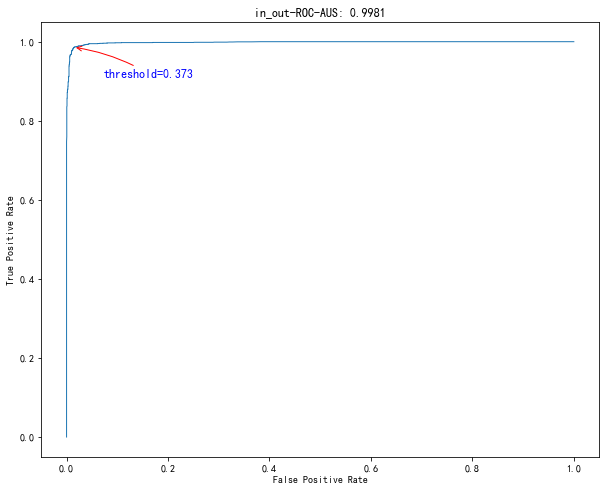

In [16]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, lw=1)    # 画出当前分割数据的ROC曲线

plt.xlim([-0.05, 1.05])     # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    # 可以使用中文，但需要导入一些库即字体
plt.title('in_out-ROC-AUS: {:.4f}'.format(roc_auc))


plt.annotate(r'threshold={:.3f}'.format(optimal_threshold), xy=(fpr[optimal_idx], tpr[optimal_idx]), xycoords='data', xytext=(+30, -30),
             textcoords='offset points', fontsize=12, color='blue',
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.1",color='red'))
plt.savefig("roc2.png")